In [1]:
import os
import shutil  # To copy files
import numpy as np
import imageio.v2 as imageio
import re  # For filtering labels

# Define paths
images_path = 'data/images'  # Multispectral and optical data
labels_path = 'data/labels'   # Original binary masks
filtered_labels_path = 'data/filtered_labels'  # New directory for valid labels

# Ensure filtered labels directory exists
os.makedirs(filtered_labels_path, exist_ok=True)

# Function to prepare valid labels and copy them to a new directory
def prepare_labels(labels_path, filtered_labels_path):
    label_filenames = sorted(os.listdir(labels_path))

    # Keep only filenames that match an integer (e.g., "5.png", not "5_275.png")
    valid_labels = sorted([f for f in label_filenames if re.match(r'^\d+\.png$', f)])

    # Copy valid labels to the new directory
    for label in valid_labels:
        shutil.copy(os.path.join(labels_path, label), os.path.join(filtered_labels_path, label))

    print(f"Valid labels copied to {filtered_labels_path}: {valid_labels}")  # Debugging output
    return valid_labels

# Step 1: Prepare valid labels and save them in the new directory
valid_labels = prepare_labels(labels_path, filtered_labels_path)

Valid labels copied to data/filtered_labels: ['0.png', '1.png', '10.png', '100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '11.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115.png', '116.png', '117.png', '118.png', '119.png', '12.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '127.png', '128.png', '129.png', '13.png', '130.png', '131.png', '132.png', '133.png', '134.png', '135.png', '136.png', '137.png', '138.png', '139.png', '14.png', '140.png', '141.png', '142.png', '143.png', '144.png', '145.png', '146.png', '147.png', '148.png', '149.png', '15.png', '150.png', '151.png', '152.png', '153.png', '154.png', '155.png', '156.png', '157.png', '158.png', '159.png', '16.png', '160.png', '161.png', '162.png', '163.png', '164.png', '165.png', '166.png', '167.png', '168.png', '169.png', '17.png', '170.png', '171.png', '172.png', '173.png', '174.png', '175.png', '176.png', '177.png'

In [2]:
##Preparing Data 
import os
import numpy as np
import imageio.v2 as imageio

# Define paths
images_path = 'data/images'  # Multispectral and optical data
labels_path = 'data/filtered_labels'   # Binary masks for water segmentation

# Function to load and preprocess data
def load_and_preprocess_data(images_path, labels_path):
    images = []
    labels = []
    image_filenames = sorted(os.listdir(images_path))
    label_filenames = sorted(os.listdir(labels_path))

    for img_file, label_file in zip(image_filenames, label_filenames):
        # Load the image
        img = imageio.imread(os.path.join(images_path, img_file))
        label = imageio.imread(os.path.join(labels_path, label_file))

        # Check the shape
        if img.ndim == 3 and img.shape[2] == 12 and label.shape == (128, 128):
            # Normalize the image to [0, 1]
            img_normalized = img.astype(np.float32) / 255.0  # Assuming original range is [0, 255]
            
            images.append(img_normalized)
            labels.append(label.astype(np.uint8))  # Ensure labels are in uint8 format

    return np.array(images), np.array(labels)

# Load and preprocess the data
X, Y = load_and_preprocess_data(images_path, labels_path)

# Print shapes for verification
print(f'Images shape: {X.shape}')  # Should be (num_samples, height, width, num_bands)
print(f'Labels shape: {Y.shape}')  # Should be (num_samples, height, width)

Images shape: (306, 128, 128, 12)
Labels shape: (306, 128, 128)


In [3]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from keras.optimizers import Adam
import tensorflow.keras.backend as K


def mean_iou(y_true, y_pred):
    y_true = K.cast(y_true, K.floatx())  # Convert to float32
    y_pred = K.round(y_pred)  # Threshold predictions at 0.5
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

def precision(y_true, y_pred):
    y_pred = K.round(y_pred)
    y_true = K.cast(y_true, K.floatx())  # Ensure both have the same dtype
    y_pred = K.cast(y_pred, K.floatx())
    
    tp = K.sum(y_true * y_pred)  # True Positives
    fp = K.sum((1 - y_true) * y_pred)  # False Positives
    return tp / (tp + fp + K.epsilon())

# Recall
def recall(y_true, y_pred):
    y_pred = K.round(y_pred)
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.cast(y_pred, K.floatx())
    
    tp = K.sum(y_true * y_pred)  # True Positives
    fn = K.sum(y_true * (1 - y_pred))  # False Negatives
    return tp / (tp + fn + K.epsilon())

# F1-score
def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r + K.epsilon())
    
# Function to build U-Net model
def unet(sz=(128, 128, 12)):
    x = Input(sz)
    inputs = x
    
    # Downsampling
    f = 4  # Initial number of filters
    layers = []
    for i in range(6):
        x = Conv2D(f, 3, activation='relu', padding='same')(x)
        x = Conv2D(f, 3, activation='relu', padding='same')(x)
        layers.append(x)
        x = MaxPooling2D()(x)
        f *= 2  # Double the filters at each level
    
    ff2 = 64  # Filters for the first upsampling layer

    # Bottleneck
    j = len(layers) - 1
    x = Conv2D(f, 3, activation='relu', padding='same')(x)
    x = Conv2D(f, 3, activation='relu', padding='same')(x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same')(x)
    x = Concatenate(axis=3)([x, layers[j]])
    j -= 1
    
    # Upsampling
    for i in range(5):
        ff2 //= 2
        f //= 2
        x = Conv2D(f, 3, activation='relu', padding='same')(x)
        x = Conv2D(f, 3, activation='relu', padding='same')(x)
        x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same')(x)
        x = Concatenate(axis=3)([x, layers[j]])
        j -= 1

    # Classification
    x = Conv2D(f, 3, activation='relu', padding='same')(x)
    x = Conv2D(f, 3, activation='relu', padding='same')(x)
    outputs = Conv2D(1, 1, activation='sigmoid')(x)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model



In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)

X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

Y_train = np.expand_dims(Y_train, axis=-1)
Y_val = np.expand_dims(Y_val, axis=-1)
Y_test = np.expand_dims(Y_test, axis=-1)

print(f"Train Set: {X_train.shape}, {Y_train.shape}")
print(f"Validation Set: {X_val.shape}, {Y_val.shape}")
print(f"Test Set: {X_test.shape}, {Y_test.shape}")

# Create U-Net model
model = unet()
# Compile the model with these metrics
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[mean_iou ,precision ,recall ,f1_score])

# Define callbacks
checkpoint = ModelCheckpoint("unet_best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,  
    batch_size=16,  
    callbacks=[checkpoint, early_stopping]
)


Train Set: (244, 128, 128, 12), (244, 128, 128, 1)
Validation Set: (31, 128, 128, 12), (31, 128, 128, 1)
Test Set: (31, 128, 128, 12), (31, 128, 128, 1)
Epoch 1/100


C:\Users\elbostan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_92']. Received: the structure of inputs=*
  warnings.warn(


15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - f1_score: 0.1446 - loss: 0.6941 - mean_iou: 0.0833 - precision: 0.1644 - recall: 0.1975
Epoch 1: val_loss improved from inf to 0.67240, saving model to unet_best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - f1_score: 0.1347 - loss: 0.6934 - mean_iou: 0.0775 - precision: 0.1655 - recall: 0.1826 - val_f1_score: 8.1860e-04 - val_loss: 0.6724 - val_mean_iou: 4.0961e-04 - val_precision: 0.2452 - val_recall: 4.1013e-04
Epoch 2/100
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - f1_score: 6.6210e-05 - loss: 0.6625 - mean_iou: 3.3108e-05 - precision: 0.2429 - recall: 3.3112e-05
Epoch 2: val_loss improved from 0.67240 to 0.49720, saving model to unet_best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - f1_score: 6.2011e-05 - loss: 0.6588 - mean_iou: 3.1008e-05 - precision: 0.2283 - recall: 3.1013e-05 - val_f1_score: 0.0000e+00 - val_loss: 0.4972 - val_mean_iou: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
15/16

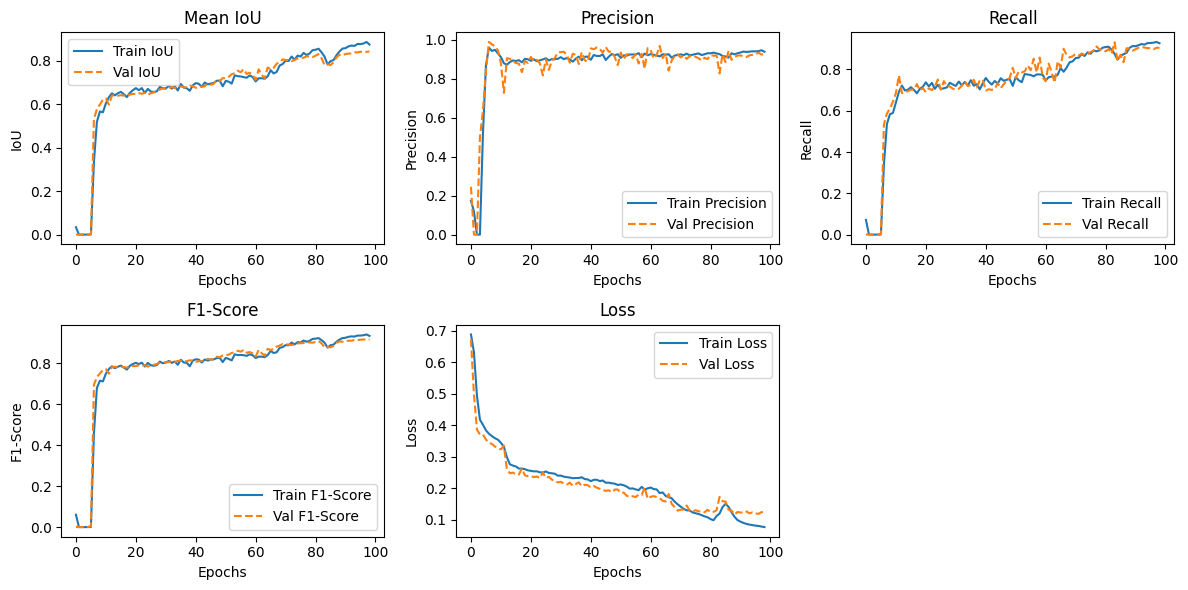

In [12]:
import matplotlib.pyplot as plt

# Extract training history
history_dict = history.history

# Plot metrics
plt.figure(figsize=(12, 6))

# Mean IoU
plt.subplot(2, 3, 1)
plt.plot(history_dict['mean_iou'], label='Train IoU')
plt.plot(history_dict['val_mean_iou'], label='Val IoU', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Mean IoU')
plt.legend()

# Precision
plt.subplot(2, 3, 2)
plt.plot(history_dict['precision'], label='Train Precision')
plt.plot(history_dict['val_precision'], label='Val Precision', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()

# Recall
plt.subplot(2, 3, 3)
plt.plot(history_dict['recall'], label='Train Recall')
plt.plot(history_dict['val_recall'], label='Val Recall', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()

# F1-Score
plt.subplot(2, 3, 4)
plt.plot(history_dict['f1_score'], label='Train F1-Score')
plt.plot(history_dict['val_f1_score'], label='Val F1-Score', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('F1-Score')
plt.legend()

# Loss
plt.subplot(2, 3, 5)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# Evaluate the model on the test set
test_loss, test_iou, test_precision, test_recall, test_f1 = model.evaluate(X_test, Y_test, batch_size=16)

# Print test results
print(f"Test Loss: {test_loss}")
print(f"Test Mean IoU: {test_iou}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - f1_score: 0.8559 - loss: 0.1479 - mean_iou: 0.7484 - precision: 0.8827 - recall: 0.8311
Test Loss: 0.1581040769815445
Test Mean IoU: 0.7392403483390808
Test Precision: 0.8820863962173462
Test Recall: 0.820321798324585
Test F1 Score: 0.8497830629348755
